In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
load_dataset = False
load_model = False

# Dataset preparing

In [3]:
from src.lib.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd
import torch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = True
load_dataset = True

In [5]:
true_dist_size = 1000
training_dataset_size = int(0.8 * true_dist_size)
alpha = 1
dataset = FactDatasetGenerator(number_person=100,  distribution="zipf", dataset_folder='../src/data/', food_list_name="food_list_small.txt",true_dist_size=true_dist_size, experiment_path="../src/experiment/small_dataset/data/")

In [6]:
if load_dataset:
    dataset.load_dataset()
    true_dist = dataset.true_dist 
    training_data = dataset.training_data
else:
    # Generate all possible facts
    temp = dataset.generate_all_possibilities()
    # Sample true dist (zipf)
    true_dist = dataset.generate_true_dist(alpha=alpha)
    # Sample training data uniformly, %80 of true dist
   
    training_data = dataset.sample_training_data(training_dataset_size,true_dist.tolist())
    print(dataset.vocab_size)
    print(len(temp))

202
10100


In [7]:
true_dist_df = pd.DataFrame(true_dist,columns=["facts"])

In [8]:
true_dist_df

,facts
0,"Bendite,beef tartare"
1,"El,carrot cake"
2,"Shaina,gyoza"
3,"Rossy,samosa"
4,"Shaun,club sandwich"
...,...
995,"Flore,pad thai"
996,"Violetta,club sandwich"
997,"Mirilla,donuts"
998,"Farly,ravioli"


In [9]:
true_duplicates_count = true_dist_df.groupby(list(true_dist_df.columns)).size().reset_index(name='count_true')


In [10]:
true_duplicates_count

,facts,count_true
0,"Albertine,apple pie",1
1,"Albertine,beef tartare",1
2,"Albertine,french fries",1
3,"Albertine,ice cream",1
4,"Albertine,spaghetti carbonara",1
...,...,...
507,"Winfield,tiramisu",1
508,"Xenos,baklava",1
509,"Xenos,french toast",3
510,"Zeb,cheese plate",1


In [11]:
training_dist_df = pd.DataFrame(training_data,columns=["facts"])
training_duplicates_count = training_dist_df.groupby(list(training_dist_df.columns)).size().reset_index(name='count_train')

In [12]:
training_duplicates_count

,facts,count_train
0,"Albertine,french fries",1
1,"Albertine,ice cream",1
2,"Albertine,spaghetti carbonara",1
3,"Archibald,omelette",2
4,"Archibald,pizza",1
...,...,...
418,"Winfield,seaweed salad",1
419,"Winfield,tiramisu",1
420,"Xenos,baklava",1
421,"Xenos,french toast",3


In [13]:
import torch
## get the training  datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.tokenized_training_data]


In [14]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [15]:
## import mingpt
sys.path.append('minGPT/')
from src.minGPT.mingpt.model import GPT
from src.minGPT.mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocab_size
model_config.model_type = None
model_config.block_size = 3

# model_config.model_type = 'gpt-nano'
# model_config.vocab_size = dataset.vocab_size
# model_config.block_size = 2

model = GPT(model_config).to(device)

number of parameters: 37.93M


In [16]:
# create a Trainer object
from src.minGPT.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cuda


# Training the model

In [17]:
best_iter = 100000000000000
best_epoch = 0
def batch_end_callback(trainer):
    global best_iter
    global best_epoch
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 100:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        if trainer.loss.item() < best_iter:
            best_iter = trainer.loss.item()
            best_epoch = trainer.iter_num
            torch.save(model.state_dict(), dataset.experiment_path[:-5] + "model.pt")
trainer.set_callback('on_batch_end', batch_end_callback)

if load_model:
    model.load_state_dict(torch.load(dataset.experiment_path[:-5]+ "model.pt"))
else:
    trainer.run()
    print(f"Best loss is: {best_iter} on epoch: {best_epoch}")

C:\Users\Batu\AppData\Local\Temp\ipykernel_38464\4291040295.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
C:\Users\Batu\AppData\Local\Temp\ipykernel_38464\4291040295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx][1:], dtype=torch.long)


iter_dt 0.00ms; iter 0: train loss 5.51930
iter_dt 2.75ms; iter 100: train loss 3.13728
iter_dt 2.65ms; iter 200: train loss 3.02431
iter_dt 2.65ms; iter 300: train loss 2.87767
iter_dt 2.70ms; iter 400: train loss 2.99615
iter_dt 2.75ms; iter 500: train loss 3.00743
iter_dt 2.75ms; iter 600: train loss 2.71108
iter_dt 2.65ms; iter 700: train loss 2.94277
iter_dt 2.55ms; iter 800: train loss 2.80742
iter_dt 2.55ms; iter 900: train loss 2.79740
iter_dt 2.80ms; iter 1000: train loss 3.00692
iter_dt 2.55ms; iter 1100: train loss 2.72116
iter_dt 2.65ms; iter 1200: train loss 2.74233
iter_dt 2.60ms; iter 1300: train loss 2.87459
iter_dt 2.60ms; iter 1400: train loss 2.74971
iter_dt 2.65ms; iter 1500: train loss 2.76788
iter_dt 2.65ms; iter 1600: train loss 2.65292
iter_dt 2.60ms; iter 1700: train loss 2.67550
iter_dt 2.60ms; iter 1800: train loss 2.82998
iter_dt 2.60ms; iter 1900: train loss 2.63101
iter_dt 2.55ms; iter 2000: train loss 2.72308
iter_dt 2.60ms; iter 2100: train loss 2.51961


In [18]:
# now let's perform some evaluation
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(202, 512)
    (wpe): Embedding(3, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_fe

# Generate unconditioned facts

In [19]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [20]:
n_sequences = 1000
from collections import defaultdict
collected_generations = []

for _ in range(n_sequences):
    x = torch.Tensor([0]).unsqueeze(0).long().to(device)
    y_gen = model.generate(x, 2, do_sample=True)
    name = food_item = dataset.decode([y_gen[0][1]])[0]
    food_item = dataset.decode([y_gen[0][2]])[0]
    collected_generations.append(f"{name},{food_item}")

In [21]:
collected_generations_df = pd.DataFrame(collected_generations, columns=["facts"])

In [22]:
collected_generations_counts = collected_generations_df.groupby(list(collected_generations_df.columns)).size().reset_index(name='count_generated')


In [23]:
collected_generations_counts

,facts,count_generated
0,"Albertine,ice cream",1
1,"Archibald,omelette",6
2,"Archibald,pizza",1
3,"Arlen,chocolate cake",2
4,"Astrix,baby back ribs",1
...,...,...
330,"lasagna ,grilled cheese sandwich",1
331,"macarons ,guacamole",1
332,"miso soup ,escargots",1
333,"poutine ,clam chowder",1


In [24]:
# Merge true dist and training dist dataframes, outer is used to include data that is not in training data as well
merged_df = pd.merge(true_duplicates_count, training_duplicates_count, on='facts', how='outer')

In [25]:
# Add generated_df to true and training dfs 
# outer can be used to include all facts in true dist
# inner can be used to only show the comparison of generated facts
comparison_df = pd.merge(merged_df, collected_generations_counts, on='facts', how='outer')

In [26]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Albertine,apple pie",1.0,NaN,NaN
1,"Albertine,beef tartare",1.0,NaN,NaN
2,"Albertine,french fries",1.0,1.0,NaN
3,"Albertine,ice cream",1.0,1.0,1.0
4,"Albertine,spaghetti carbonara",1.0,1.0,NaN
...,...,...,...,...
541,"lasagna ,grilled cheese sandwich",NaN,NaN,1.0
542,"macarons ,guacamole",NaN,NaN,1.0
543,"miso soup ,escargots",NaN,NaN,1.0
544,"poutine ,clam chowder",NaN,NaN,1.0


In [27]:
# Fill in 0 for facts that not appear
comparison_df = comparison_df.fillna(0)

In [28]:
# Normalize the counts by length
comparison_df["count_generated"] = comparison_df['count_generated']/len(collected_generations)
comparison_df["count_train"] = comparison_df['count_train']/len(training_data)
comparison_df["count_true"] = comparison_df['count_true']/len(true_dist)


In [29]:
comparison_df = comparison_df.sort_values(by=['count_generated'], ascending=False)

In [30]:
comparison_df

,facts,count_true,count_train,count_generated
188,"Flore,pad thai",0.112,0.11250,0.101
337,"Mirilla,donuts",0.059,0.06375,0.066
444,"Shaun,club sandwich",0.046,0.03875,0.040
243,"Jeffie,macarons",0.016,0.01750,0.022
260,"Juliana,waffles",0.018,0.01750,0.019
...,...,...,...,...
151,"Enid,tiramisu",0.001,0.00125,0.000
380,"Nicol,peking duck",0.001,0.00000,0.000
383,"Ninnetta,beignets",0.001,0.00000,0.000
386,"Olga,foie gras",0.001,0.00125,0.000


In [31]:
comparison_df.sum()

facts              Flore,pad thai Mirilla,donuts Shaun,club sandw...
count_true                                                       1.0
count_train                                                      1.0
count_generated                                                  1.0
dtype: object

<Axes: >

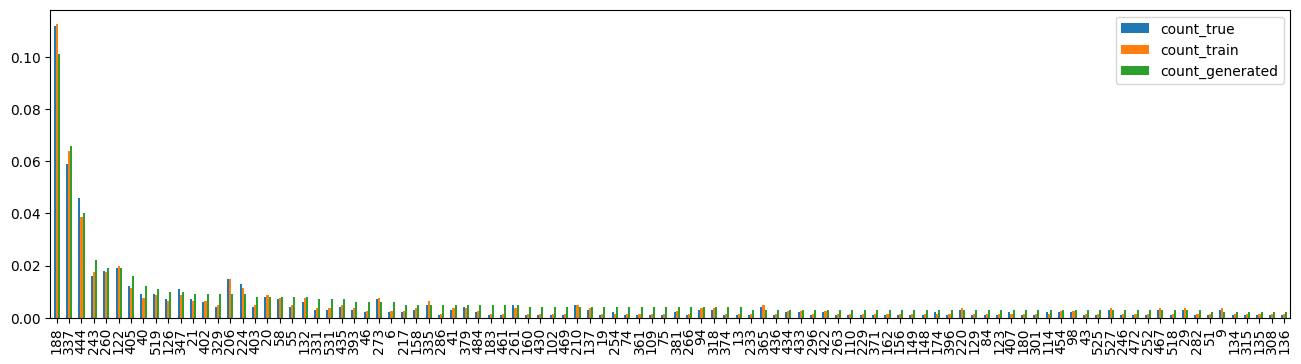

In [32]:
import matplotlib.pyplot as plt
import numpy as np
# Only the top 100 facts graphed for visibility 
comparison_df[:100].plot.bar(figsize=(16, 4))

## Hallucination rates

In [33]:
# True hallucination rate (generations not in true dist)
true_hallucinations = pd.merge(collected_generations_counts, true_duplicates_count, on='facts', how='left')


In [34]:
true_hallucinations

,facts,count_generated,count_true
0,"Albertine,ice cream",1,1.0
1,"Archibald,omelette",6,2.0
2,"Archibald,pizza",1,2.0
3,"Arlen,chocolate cake",2,3.0
4,"Astrix,baby back ribs",1,1.0
...,...,...,...
330,"lasagna ,grilled cheese sandwich",1,NaN
331,"macarons ,guacamole",1,NaN
332,"miso soup ,escargots",1,NaN
333,"poutine ,clam chowder",1,NaN


In [35]:
true_hallucinations = true_hallucinations.fillna(0)
try:
    number_of_true_hallucinations =true_hallucinations["count_true"].value_counts()[0]
    true_hallucinations_rate = number_of_true_hallucinations / len(collected_generations)
except:
    number_of_true_hallucinations = 0
    true_hallucinations_rate = 0
print(f"Rate of true hallucinations: {true_hallucinations_rate} ")

Rate of true hallucinations: 0.034 


In [36]:
# Naive hallucination rate (every generation not in training data)
naive_hallucinations = pd.merge(collected_generations_counts, training_duplicates_count, on='facts', how='left')

In [37]:
naive_hallucinations

,facts,count_generated,count_train
0,"Albertine,ice cream",1,1.0
1,"Archibald,omelette",6,2.0
2,"Archibald,pizza",1,1.0
3,"Arlen,chocolate cake",2,3.0
4,"Astrix,baby back ribs",1,1.0
...,...,...,...
330,"lasagna ,grilled cheese sandwich",1,NaN
331,"macarons ,guacamole",1,NaN
332,"miso soup ,escargots",1,NaN
333,"poutine ,clam chowder",1,NaN


In [38]:
naive_hallucinations = naive_hallucinations.fillna(0)
try:
    number_of_naive_hallucinations = naive_hallucinations["count_train"].value_counts()[0]
    naive_hallucinations_rate = number_of_naive_hallucinations / len(collected_generations)
except:
    number_of_naive_hallucinations = 0
    naive_hallucinations_rate = 0

print(f"Rate of naive hallucinations: {naive_hallucinations_rate} ")

Rate of naive hallucinations: 0.034 


In [39]:
naive_hallucinations_df = naive_hallucinations[naive_hallucinations["count_train"] == 0]

In [40]:
naive_hallucinations_df

,facts,count_generated,count_train
8,"Astrix,pork chop",1,0.0
18,"Benita,pad thai",1,0.0
49,"Deane,tuna tartare",1,0.0
61,"Deidre,macaroni and cheese",1,0.0
75,"Edith,Augustine",1,0.0
76,"Edith,Valerie",1,0.0
95,"Ermentrude,ramen",1,0.0
108,"Felicio,Violetta",1,0.0
132,"Jacinthe,paella",1,0.0
135,"Jammal,Kathlin",1,0.0


In [41]:
hallucinations_list = naive_hallucinations_df["facts"].tolist()

### Monofact rate

In [42]:
try:
    MF = training_duplicates_count["count_train"].value_counts()[1] / len(training_data)
    mf_df = training_duplicates_count[training_duplicates_count["count_train"] == 1]
    monofact_list = mf_df["facts"].tolist()
except:
    MF = 0
MF

0.43875

### Miscalibration

In [43]:
from src.lib.calibration import miscalibration

In [44]:
comparison_sorted_by_generated = comparison_df.sort_values(by='count_generated', ascending=False)

In [45]:
miscalibration_rate = miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_true'])
miscalibration_rate

Adaptive binning with 9 bins
bin with g_proba / p_proba 0.101 0.112
bin with g_proba / p_proba 0.10600000000000001 0.105
bin with g_proba / p_proba 0.10899999999999999 0.09399999999999999
bin with g_proba / p_proba 0.10900000000000004 0.08700000000000002
bin with g_proba / p_proba 0.10900000000000003 0.05500000000000001
bin with g_proba / p_proba 0.11000000000000007 0.054000000000000006
bin with g_proba / p_proba 0.11100000000000006 0.066
bin with g_proba / p_proba 0.11100000000000008 0.07100000000000001
bin with g_proba / p_proba 0.11100000000000008 0.10600000000000004
bin with g_proba / p_proba 0.023000000000000013 0.2500000000000001


0.2577857142857143

In [46]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_train'])

Adaptive binning with 9 bins
bin with g_proba / p_proba 0.101 0.1125
bin with g_proba / p_proba 0.10600000000000001 0.10250000000000001
bin with g_proba / p_proba 0.10899999999999999 0.09125000000000003
bin with g_proba / p_proba 0.10900000000000004 0.09125000000000003
bin with g_proba / p_proba 0.10900000000000003 0.06375000000000001
bin with g_proba / p_proba 0.11000000000000007 0.0625
bin with g_proba / p_proba 0.11100000000000006 0.07750000000000001
bin with g_proba / p_proba 0.11100000000000008 0.08625
bin with g_proba / p_proba 0.11100000000000008 0.12375
bin with g_proba / p_proba 0.023000000000000013 0.18875


0.21769325396825395

### Check if it holds

In [47]:
unique_names = len(set([t[1] for t in train_dataset]))
unique_foods = len(set([t[2] for t in train_dataset]))
# Possible generations
POSS_GENERATIONS = unique_names * unique_foods

# Facts to all possibilities - facts, approximated
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS = 300 * len(training_duplicates_count) / (POSS_GENERATIONS - len(training_duplicates_count))

In [48]:
HALLUCINATION_RATE = true_hallucinations_rate

#MF = 0.43875

MISCALIBRATION = miscalibration_rate

In [49]:
MF

0.43875

In [50]:
MISCALIBRATION

0.2577857142857143

In [51]:
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

0.1984123881878179

In [52]:
MF - MISCALIBRATION

0.1809642857142857

In [53]:
7 / np.sqrt(len(training_data))

0.24748737341529162

In [54]:
estimated_hallucination_rate = MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS
estimated_hallucination_rate

-0.2649354758888238

In [55]:
HALLUCINATION_RATE

0.034

In [56]:
HALLUCINATION_RATE > MF - MISCALIBRATION

False

In [57]:
HALLUCINATION_RATE > MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

True

In [58]:
import json
def save_results():
    experiment = {}
    experiment['number of person'] = dataset.number_person
    experiment['food_list'] = dataset.food_list_name
    experiment['true_dist_size'] = dataset.true_dist_size
    experiment['training_set_size'] = len(training_data)
    experiment['zipf_alpha'] = alpha
    experiment['monofact_rate'] = MF
    experiment['miscalibration_rate'] = MISCALIBRATION
    experiment['facts_to_possible_hallucinations_ratio'] = APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS
    experiment['estimated_hallucinations_rate'] = estimated_hallucination_rate
    experiment['naive_hallucinations_rate'] = naive_hallucinations_rate
    experiment['true_hallucinations_rate'] = true_hallucinations_rate
    
    json_str = json.dumps(experiment)
    with open('experiment/experiments.json', 'a') as file:
        file.write(json_str + '\n')
        
    

In [59]:
#save_results()

In [60]:
x = torch.Tensor([0]).unsqueeze(0).long().to(device)
output, loss, hidden_states = model(x,output_hidden_states=True)
print(hidden_states)

[tensor([[[ 2.0796e-02,  8.9657e-03, -6.4650e-03, -1.8630e-02, -5.7323e-03,
           1.8417e-02,  1.7914e-02,  6.1629e-02,  5.3536e-02,  1.1334e-02,
           1.7572e-02,  4.0279e-02, -7.2621e-02, -1.4879e-02,  4.1121e-02,
           3.7028e-02,  4.4371e-02,  7.8964e-02, -7.4553e-03, -2.5165e-02,
          -8.1933e-02, -4.0355e-02,  5.6867e-02,  3.4438e-02,  7.1217e-03,
           4.1960e-02, -4.7407e-02,  2.2690e-02, -3.2619e-02, -4.2211e-02,
          -7.9445e-02, -3.9048e-02, -1.5100e-02, -1.6916e-02, -3.0170e-02,
           3.5362e-02,  1.7993e-02, -3.8807e-02,  6.7489e-03,  3.6690e-02,
           2.0515e-02, -1.6652e-02, -2.1622e-02, -4.9308e-02,  4.8472e-02,
           5.0284e-02,  4.5561e-05, -5.6428e-02, -1.5680e-02, -3.0394e-02,
           1.3529e-02,  6.0318e-02, -7.9437e-02, -3.6272e-02,  1.2556e-02,
          -2.5714e-02,  1.5133e-02,  3.6589e-02,  3.0724e-02, -4.3153e-02,
          -3.6944e-02, -3.1468e-02, -5.2988e-02, -1.3803e-02,  3.5970e-02,
          -2.1776e-02,  

In [61]:
last_hidden_state = hidden_states[-1]


In [62]:
last_hidden_state.flatten().shape

torch.Size([512])

In [63]:
tokenized_hallucinations = dataset.tokenize_data(hallucinations_list)
tokenized_monofacts = dataset.tokenize_data(monofact_list)

In [64]:
final_hidden_states = []

monofact_embeddings = []
normal_fact_embeddings = []
for fact in train_dataset:
    output, loss, hidden_states = model(fact.unsqueeze(0).long().to(device),output_hidden_states=True)
    fact = fact.cpu().tolist()
    if fact in tokenized_monofacts:
        monofact_embeddings.append((fact, hidden_states[-1].flatten()))
    else:
        normal_fact_embeddings.append((fact,hidden_states[-1].flatten()))
    final_hidden_states.append((fact, hidden_states[-1].flatten()))
    

In [65]:
hallucination_embeddings = []
for fact in tokenized_hallucinations:
    output, loss, hidden_states = model(torch.tensor(fact).unsqueeze(0).long().to(device),output_hidden_states=True)
    
    hallucination_embeddings.append((fact, hidden_states[-1].flatten()))
    

In [66]:
print(len(final_hidden_states))
print(len(hallucination_embeddings))
print(len(monofact_embeddings))
print(len(normal_fact_embeddings))

800
34
351
449


In [67]:

def mahalanobis_distance(vector1, vector2, covariance_matrix):
    diff = vector1 - vector2
    inv_cov = torch.inverse(covariance_matrix)
    return torch.sqrt(torch.matmul(torch.matmul(diff, inv_cov), diff))




In [68]:
monofact_similarity = []
normal_fact_similarity = []
for hallucination, hallucination_embedding in hallucination_embeddings:
    for monofact, monofact_embedding in monofact_embeddings:
        monofact_similarity.append(torch.norm(hallucination_embedding - monofact_embedding, p=1).cpu().detach().numpy())
        #monofact_similarity.append(mahalanobis_distance(hallucination_embedding, monofact_embedding, torch.eye(512*3).to(device)).cpu().detach().numpy())
    for fact, fact_embedding in normal_fact_embeddings:
        normal_fact_similarity.append(torch.norm(hallucination_embedding - fact_embedding, p=1).cpu().detach().numpy())
        #normal_fact_similarity.append(mahalanobis_distance(hallucination_embedding, fact_embedding, torch.eye(512*3).to(device)).cpu().detach().numpy())

In [69]:
np.asarray(monofact_similarity).mean()

1190.2795

In [70]:
np.asarray(normal_fact_similarity).mean()

1178.6466

In [71]:
len(monofact_similarity)

11934

In [72]:
len(normal_fact_similarity)

15266

### Saving Embeddings

In [73]:
import json
with open("../src/experiment/monofact_embeddings.json","w") as f:
    for line in monofact_embeddings:
        f.write(json.dumps((line[0],line[1].tolist())) + "\n")
with open("../src/experiment/hallucination_embeddings.json","w") as f:
    for line in hallucination_embeddings:
        f.write(json.dumps((line[0],line[1].tolist())) + "\n")
with open("../src/experiment/normal_fact_embeddings.json","w") as f:
    for line in normal_fact_embeddings:
        f.write(json.dumps((line[0],line[1].tolist())) + "\n")

### Loading embeddings

In [74]:
loaded_monofact_embeddings = []
loaded_normal_fact_embeddings = []
loaded_hallucination_embeddings = []


with open("../src/experiment/monofact_embeddings.json","r") as f:
    for line in f:
        loaded_monofact_embeddings.append(json.loads(line))
with open("../src/experiment/hallucination_embeddings.json","r") as f:
    for line in f:
        loaded_hallucination_embeddings.append(json.loads(line))
with open("../src/experiment/normal_fact_embeddings.json","r") as f:
    for line in f:
        loaded_normal_fact_embeddings.append(json.loads(line))


In [78]:
monofact_embeddings = []
hallucination_embeddings = []
normal_fact_embeddings = []
for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
    monofact_embeddings.append((loaded_monofact, torch.tensor(loaded_monofact_embedding)))
for loaded_hallucination, loaded_hallucination_embedding in loaded_hallucination_embeddings:
    hallucination_embeddings.append((loaded_hallucination, torch.tensor(loaded_hallucination_embedding)))
for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
    normal_fact_embeddings.append((loaded_normal_fact, torch.tensor(loaded_normal_fact_embedding)))

[([0, 7, 180],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.0666,  3.3867,  0.0594])),
 ([0, 82, 85],
  tensor([ 0.5362, -0.0391,  4.4602,  ..., -0.5822,  0.8617,  0.7569])),
 ([0, 54, 12],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  1.4260,  1.0563, -1.2991])),
 ([0, 66, 67],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.3304, -1.2571, -1.7041])),
 ([0, 161, 67],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.3070, -0.5973, -0.1049])),
 ([0, 161, 30],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.2279, -0.5496, -0.0293])),
 ([0, 82, 61],
  tensor([ 0.5362, -0.0391,  4.4602,  ..., -0.5703, -0.5766,  0.7296])),
 ([0, 114, 122],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.1944,  3.2436,  0.0386])),
 ([0, 17, 2],
  tensor([ 0.5362, -0.0391,  4.4602,  ..., -1.4377, -0.1571,  1.6726])),
 ([0, 5, 12],
  tensor([ 0.5362, -0.0391,  4.4602,  ...,  0.6330,  1.0203, -1.6901])),
 ([0, 181, 160],
  tensor([ 0.5362, -0.0391,  4.4602,  ..., -0.4523,  0.3680, -0.3557])),
 ([0, 75, 76],
  tensor([ 0.